<a href="https://colab.research.google.com/github/DSGPproject/DSGP_model/blob/main/the_one_with_epoch90s_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=100

In [32]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/dataset/unchanged",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 895 files belonging to 8 classes.


['Anthracnose',
 'algal leaf',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

20

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
len(train_ds)

20

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [13]:
def random_hue(image, max_delta=0.2):
    return tf.image.adjust_hue(image, tf.random.uniform([], -max_delta, max_delta))

def random_brightness(image, max_delta=0.2):
    return tf.image.adjust_brightness(image, tf.random.uniform([], 1-max_delta, 1+max_delta))


data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.Lambda(lambda x: random_hue(x)),
    layers.Lambda(lambda x: random_brightness(x)),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
len(train_ds)

20

In [16]:
len(test_ds)

3

In [17]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [18]:

pretrained_model_without_top_layer = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Display the summary of the model to see layer names
pretrained_model_without_top_layer.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [19]:
num_of_classes = 8

model = tf.keras.Sequential([
    pretrained_model_without_top_layer,
    layers.GlobalMaxPooling2D(),  # Global max pooling layer
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_of_classes, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d (Glob  (None, 1280)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 2917960 (11.13 MB)
Trainable params: 288

In [33]:
model.compile(
  optimizer="adamax",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


from tensorflow.keras.callbacks import EarlyStopping


#. the EarlyStopping callback
early_stopping = EarlyStopping(
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    monitor='val_loss',  # Metric to monitor for improvement (e.g., 'val_loss' or 'val_accuracy')
    mode='min'  # 'min' means training will stop when the quantity monitored has stopped decreasing (e.g., val_loss)
)

# Assuming you have a validation dataset (val_ds)
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/100
20/20 [==============================] - 151s 7s/step - loss: 1.1464 - accuracy: 0.6367 - val_loss: 6.3241 - val_accuracy: 0.1875
Epoch 2/100
20/20 [==============================] - 127s 6s/step - loss: 0.9493 - accuracy: 0.6612 - val_loss: 4.9733 - val_accuracy: 0.2500
Epoch 3/100
20/20 [==============================] - 128s 6s/step - loss: 0.8235 - accuracy: 0.7218 - val_loss: 5.4907 - val_accuracy: 0.2344
Epoch 4/100
20/20 [==============================] - 127s 6s/step - loss: 0.5761 - accuracy: 0.7905 - val_loss: 7.4814 - val_accuracy: 0.2031
Epoch 5/100
20/20 [==============================] - 127s 6s/step - loss: 0.5308 - accuracy: 0.8183 - val_loss: 7.0923 - val_accuracy: 0.2344
Epoch 6/100
20/20 [==============================] - 132s 6s/step - loss: 0.5349 - accuracy: 0.7856 - val_loss: 6.9754 - val_accuracy: 0.2188
Epoch 7/100
20/20 [==============================] - 128s 6s/step - loss: 0.4558 - accuracy: 0.8347 - val_loss: 9.2339 - val_accuracy: 0.1719


In [22]:
len(test_ds)

3

In [23]:
model.evaluate(train_ds)

20/20 [==============================] - 30s 1s/step - loss: 3.0181 - accuracy: 0.3830


[3.018124580383301, 0.38297873735427856]

In [24]:
model.evaluate(test_ds)

3/3 [==============================] - 36s 983ms/step - loss: 2.9129 - accuracy: 0.4583


[2.9129302501678467, 0.4583333432674408]

In [25]:
model.evaluate(val_ds)

2/2 [==============================] - 2s 976ms/step - loss: 2.5499 - accuracy: 0.4375


[2.5498898029327393, 0.4375]

In [26]:
accuracy = history.history['accuracy']


loss = history.history['loss']


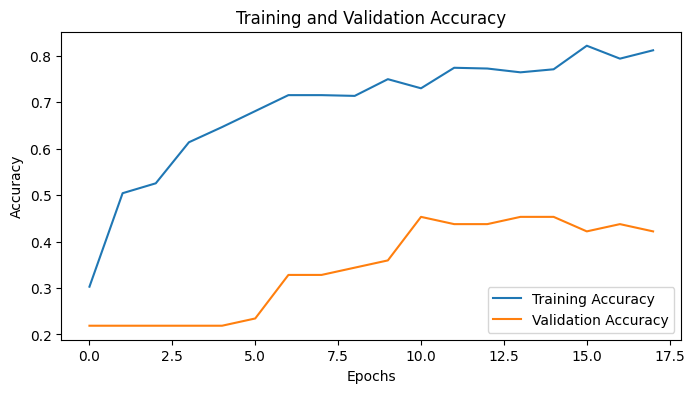

In [27]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(history.history['accuracy'])), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(len(history.history['val_accuracy'])), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


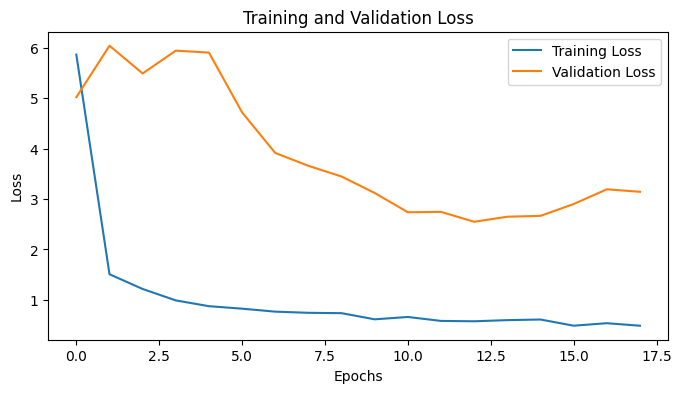

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='Training Loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


first image to predict
actual label: gray light
1/1 [==============================] - 2s 2s/step
predicted label: gray light


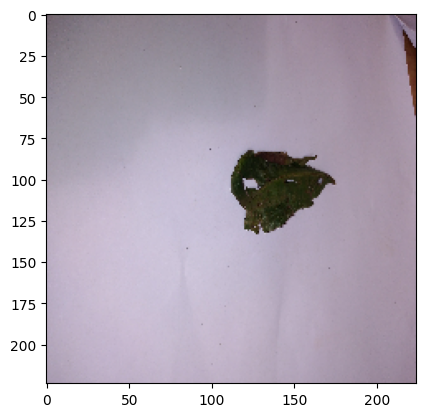

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 90ms/step


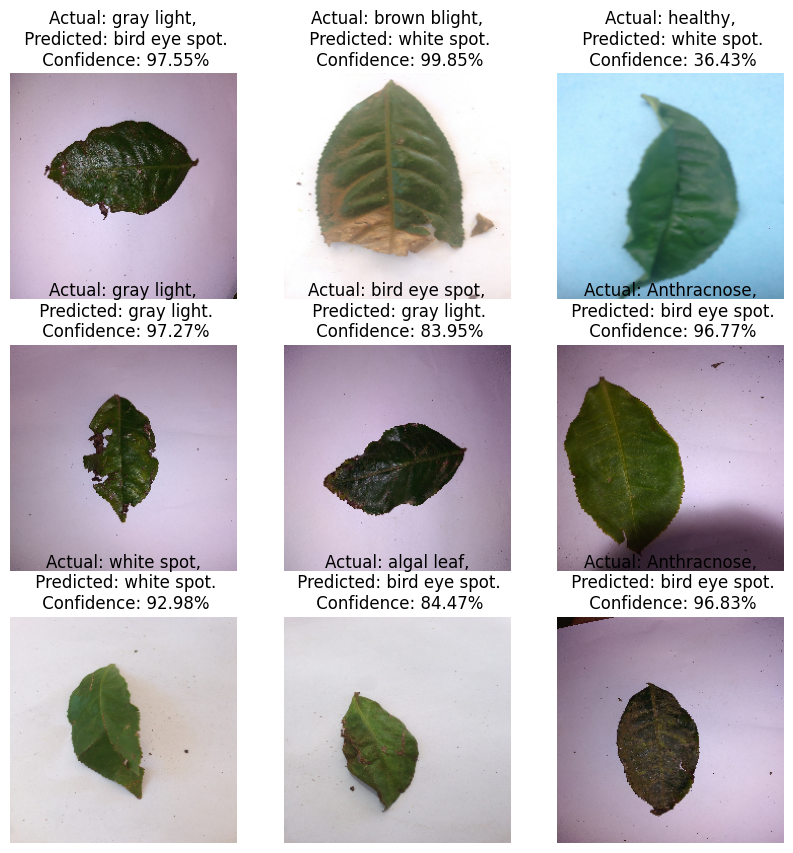

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [34]:
import os
from keras.models import load_model

model_name = 'model_transfer_latestgot90s_withchanged_maxPOOLING.hdf5'

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
